<a href="https://colab.research.google.com/github/umbertogagl97/exercise/blob/main/FGM_attack_B%26W.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import iniziali**

Import ART

In [1]:
#importa ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 13.3 MB/s 
     |████████████████████████████████| 3.4 MB 50.4 MB/s 
     |████████████████████████████████| 25.3 MB 77 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


Librerie

In [2]:
#Librerie
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

from art.estimators.classification import KerasClassifier
from art.utils import load_dataset

import cv2
from google.colab.patches import cv2_imshow

#import torch

#**Def variabili**

In [3]:
#salvataggio modello
model_save_name = 'model_DenseNet201'
path_model_save = F"/content/gdrive/My Drive/ModelliCNN/{model_save_name}" 

#immagini google
path_img_google="/content/gdrive/MyDrive/immagini_google/"

# **Collegamento google driv**e

In [4]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Dataset**

Load dataset stl10

In [5]:
#10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
#96x96 pixels, colored.
(x_train, y_train), (x_test_tot, y_test_tot), min_, max_ = load_dataset(str("stl10")) #carica train e test set

In [6]:
print(x_train.shape,x_test_tot.shape)
#5000 immagini di train e 8000 di test: 500 train e 800 test per ogni classe

(5000, 96, 96, 3) (8000, 96, 96, 3)


Riduzione training set

In [7]:
#x_train, y_train = x_train[:500], y_train[:500] #prende solo le prime 500 immagini di training

#test set ridotto
x_test, y_test = x_test_tot[:500], y_test_tot[:500]

#test set totale
#x_test, y_test = x_test_tot, y_test_tot

Stampa dimensioni

In [8]:
im_shape = x_train[0].shape
print("dimensioni immagine: ",im_shape)
print("dimensioni train set: ",x_train.shape)
print("dimensioni vettore classi reali: ",y_train.shape)
print("dimensioni test set: ",x_test.shape)
print("dimensioni vettore classi test: ",y_test.shape) #y_test contiene una riga di 10 elementi per ogni immagine di test e solo un elemento sarà posto ad 1, ovvero quello relativo alla classe reale

dimensioni immagine:  (96, 96, 3)
dimensioni train set:  (5000, 96, 96, 3)
dimensioni vettore classi reali:  (5000, 10)
dimensioni test set:  (10, 96, 96, 3)
dimensioni vettore classi test:  (10, 10)


#**Caricamento modello da drive**

In [11]:
#load model
model= tf.keras.models.load_model(path_model_save)

# **Creazione classificatore ART**

In [12]:
#creazione classificatore di tipo Keras usando il modello addestrato, poiché ART supporta solo determinati classificatori
classifier = KerasClassifier(model=model, clip_values=(min_, max_)) #è un wrapper messo a disposizione da ART per creare un classificatore a partire da un modello addestrato

# **Testing su immagini originali**

In [13]:
# Evaluate the classifier on the test set 
value_preds=classifier.predict(x_test) #contiene i valori tra 0 e 1 predetti per ognuna delle 10 classi e per ogni immagine
preds = np.argmax(value_preds, axis=1) #(le predizioni vanno da 0 a 9 e indicano la classe predetta)
acc = (np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0])*100
print("Accuracy on test set:", (round(acc,2)))
#print("classi predette: ",preds)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on test set: 70.0


# **Import FGM da github (non eseguire)**
una volta modificato il file fast_gradient.py su github si può caricare con questo codice e rimuovere l'intera classe dal notebook

copia file

In [ ]:
#copia il file da github e lo inserisce nella directory corrente (content)
#N.B. ha bisogno del link al raw del file
!wget https://raw.githubusercontent.com/umbertogagl97/adversarial-robustness-toolbox/learning/art/attacks/evasion/fast_gradient.py

In [ ]:
from fast_gradient import *

# classe FGM modificata
apply_perturbation trasforma la perturbazione in scala di grigi e la somma singolarmente ad ogni canale dell'immagine input

In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from typing import Optional, Union, TYPE_CHECKING

import numpy as np

from art.config import ART_NUMPY_DTYPE
from art.attacks.attack import EvasionAttack
from art.estimators.estimator import BaseEstimator, LossGradientsMixin
from art.estimators.classification.classifier import ClassifierMixin
from art.utils import (
    compute_success,
    get_labels_np_array,
    random_sphere,
    projection,
    check_and_transform_label_format,
)

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_LOSS_GRADIENTS_TYPE

logger = logging.getLogger(__name__)

class FastGradientMethod(EvasionAttack):
    attack_params = EvasionAttack.attack_params + [
        "norm",
        "eps",
        "eps_step",
        "targeted",
        "num_random_init",
        "batch_size",
        "minimal",
        "tensor_board",
    ]
    _estimator_requirements = (BaseEstimator, LossGradientsMixin)
	
	#costruttore della classe
    def __init__(
        self,
        estimator: "CLASSIFIER_LOSS_GRADIENTS_TYPE",
        norm: Union[int, float, str] = np.inf,
        eps: Union[int, float, np.ndarray] = 0.3,
        eps_step: Union[int, float, np.ndarray] = 0.1,
        targeted: bool = False,
        num_random_init: int = 0,
        batch_size: int = 32,
        minimal: bool = False,
        tensor_board: Union[str, bool] = False,
    ) -> None:
       
        super().__init__(estimator=estimator, tensor_board=tensor_board)
        self.norm = norm
        self.eps = eps
        self.eps_step = eps_step
        self._targeted = targeted
        self.num_random_init = num_random_init
        self.batch_size = batch_size
        self.minimal = minimal
        self._project = True
        FastGradientMethod._check_params(self)

        self._batch_id = 0
        self._i_max_iter = 0
        print("versione modificata")

    def _check_compatibility_input_and_eps(self, x: np.ndarray):
        """
        Check the compatibility of the input with `eps` and `eps_step` which are of the same shape.

        :param x: An array with the original inputs.
        """
        if isinstance(self.eps, np.ndarray):
            # Ensure the eps array is broadcastable
            if self.eps.ndim > x.ndim:
                raise ValueError("The `eps` shape must be broadcastable to input shape.")

	#funzione che genera gli adversarial samples
    def generate(self, x: np.ndarray, y: Optional[np.ndarray] = None, **kwargs) -> np.ndarray:
        """Generate adversarial samples and return them in an array.

        :param x: An array with the original inputs.
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
                  (nb_samples,). Only provide this parameter if you'd like to use true labels when crafting adversarial
                  samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect
                  (explained in this paper: https://arxiv.org/abs/1611.01236). Default is `None`.
        :param mask: An array with a mask broadcastable to input `x` defining where to apply adversarial perturbations.
                     Shape needs to be broadcastable to the shape of x and can also be of the same shape as `x`. Any
                     features for which the mask is zero will not be adversarially perturbed.
        :type mask: `np.ndarray`
        :return: An array holding the adversarial examples.
        """
        #se è stata passata la maschera delle immagini la preleva (viene passata al costruttore della classe)
        mask = self._get_mask(x, **kwargs)

        #Controlla la compatibilità tra le dimensioni di x (training set) e di eps
        self._check_compatibility_input_and_eps(x=x)

        if isinstance(self.estimator, ClassifierMixin): #controlla se il classificatore passato come input è di tipo Mixin calcola le perturbazioni in un certo modo
            y = check_and_transform_label_format(y, self.estimator.nb_classes) #funzione di utils.py che si occupa delle label di y
			
			#se y non è stato passato come input dà messaggio di errore se l'attacco è mirato, oppure usa come y le predizioni del modello passato come input
            if y is None:
                if self.targeted:
                    raise ValueError("Target labels `y` need to be provided for a targeted attack.")
                logger.info("Using model predictions as correct labels for FGM.")
                y = get_labels_np_array(self.estimator.predict(x, batch_size=self.batch_size))  # type: ignore

            if self.estimator.nb_classes > 2: #normalizza i valori reali (o predetti dal classificatore)
                y = y / np.sum(y, axis=1, keepdims=True) #sum effettua la somma degli elementi per ogni riga (ovvero somma i valori assegnati alle classi per ogni immagine, keepdims indica di non rimuovere le dimensioni ma lasciarle tutte per rendere la somma broadcastable con y iniziale

            # Return adversarial examples computed with minimal perturbation if option is active
            rate_best: Optional[float]
            
            #se al costruttore è stato passato minimal=True allora calcola la minima perturbazione, altrimenti fa un altro calcolo
            if self.minimal:
                logger.info("Performing minimal perturbation FGM.")
                adv_x_best = self._minimal_perturbation(x, y, mask)
                rate_best = 100 * compute_success(
                    self.estimator,  # type: ignore
                    x,
                    y,
                    adv_x_best,
                    self.targeted,
                    batch_size=self.batch_size,  # type: ignore
                )
            #se non è stato settato minimal=True usa la funzione compute() per calcolare gli adversarial samples    
            else:
                adv_x_best = None
                rate_best = None

                for _ in range(max(1, self.num_random_init)): #usa max perchè num_random potrebbe essere 0 o negativo
                    #calcola le immagini perturbate
                    adv_x = self._compute(
                        x,
                        x,
                        y,
                        mask,
                        self.eps,
                        self.eps,
                        self._project,
                        self.num_random_init > 0,
                    )

                    if self.num_random_init > 1:
                        rate = 100 * compute_success( #funzione di util.py che calcola il success rate dell'attacco usando x,y e adv_x
                            self.estimator,  # type: ignore
                            x,
                            y,
                            adv_x,
                            self.targeted,
                            batch_size=self.batch_size,  # type: ignore
                        )
                        if rate_best is None or rate > rate_best or adv_x_best is None:
                            rate_best = rate
                            adv_x_best = adv_x
                    else:
                        adv_x_best = adv_x

            logger.info(
                "Success rate of FGM attack: %.2f%%",
                rate_best
                if rate_best is not None
                else 100
                * compute_success(
                    self.estimator,  # type: ignore
                    x,
                    y,
                    adv_x_best,
                    self.targeted,
                    batch_size=self.batch_size,
                ),
            )
		#se il classificatore non è Mixin usa compute senza passare la maschera (se non è Mixin forse non è un classificatore)
        else:
			#se minimal=True dà errore perché ha bisogno di un classificatore
            if self.minimal:
                raise ValueError("Minimal perturbation is only supported for classification.")
            if y is None:
                # Throw error if attack is targeted, but no targets are provided
                if self.targeted:
                    raise ValueError("Target labels `y` need to be provided for a targeted attack.")

                # Use model predictions as correct outputs
                logger.info("Using model predictions as correct labels for FGM.")
                y = self.estimator.predict(x, batch_size=self.batch_size)

            adv_x_best = self._compute(
                x,
                x,
                y,
                None,
                self.eps,
                self.eps,
                self._project,
                self.num_random_init > 0,
            )

        return adv_x_best

    def _check_params(self) -> None:

        if self.norm not in [1, 2, np.inf, "inf"]:
            raise ValueError('Norm order must be either 1, 2, `np.inf` or "inf".')

        if not (
            isinstance(self.eps, (int, float))
            and isinstance(self.eps_step, (int, float))
            or isinstance(self.eps, np.ndarray)
            and isinstance(self.eps_step, np.ndarray)
        ):
            raise TypeError(
                "The perturbation size `eps` and the perturbation step-size `eps_step` must have the same type of `int`"
                ", `float`, or `np.ndarray`."
            )

        if isinstance(self.eps, (int, float)):
            if self.eps < 0:
                raise ValueError("The perturbation size `eps` has to be nonnegative.")
        else:
            if (self.eps < 0).any():
                raise ValueError("The perturbation size `eps` has to be nonnegative.")

        if isinstance(self.eps_step, (int, float)):
            if self.eps_step <= 0:
                raise ValueError("The perturbation step-size `eps_step` has to be positive.")
        else:
            if (self.eps_step <= 0).any():
                raise ValueError("The perturbation step-size `eps_step` has to be positive.")

        if isinstance(self.eps, np.ndarray) and isinstance(self.eps_step, np.ndarray):
            if self.eps.shape != self.eps_step.shape:
                raise ValueError(
                    "The perturbation size `eps` and the perturbation step-size `eps_step` must have the same shape."
                )

        if not isinstance(self.targeted, bool):
            raise ValueError("The flag `targeted` has to be of type bool.")

        if not isinstance(self.num_random_init, (int, np.int)):
            raise TypeError("The number of random initialisations has to be of type integer")

        if self.num_random_init < 0:
            raise ValueError("The number of random initialisations `random_init` has to be greater than or equal to 0.")

        if self.batch_size <= 0:
            raise ValueError("The batch size `batch_size` has to be positive.")

        if not isinstance(self.minimal, bool):
            raise ValueError("The flag `minimal` has to be of type bool.")
	
	#richiamata da minimal_perturbation e compute per calacolare il rumore da applicare
    def _compute_perturbation(
        self, batch: np.ndarray, batch_labels: np.ndarray, mask: Optional[np.ndarray]
    ) -> np.ndarray:
        # Pick a small scalar to avoid division by 0
        tol = 10e-8

        # Get gradient wrt loss; invert it if attack is targeted
        grad = self.estimator.loss_gradient(batch, batch_labels) * (1 - 2 * int(self.targeted))
        # Write summary
        if self.summary_writer is not None:
            self.summary_writer.add_scalar(
                "gradients/norm-L1/batch-{}".format(self._batch_id),
                np.linalg.norm(grad.flatten(), ord=1),
                global_step=self._i_max_iter,
            )
            self.summary_writer.add_scalar(
                "gradients/norm-L2/batch-{}".format(self._batch_id),
                np.linalg.norm(grad.flatten(), ord=2),
                global_step=self._i_max_iter,
            )
            self.summary_writer.add_scalar(
                "gradients/norm-Linf/batch-{}".format(self._batch_id),
                np.linalg.norm(grad.flatten(), ord=np.inf),
                global_step=self._i_max_iter,
            )

            if hasattr(self.estimator, "compute_losses"):
                losses = self.estimator.compute_losses(x=batch, y=batch_labels)

                for key, value in losses.items():
                    self.summary_writer.add_scalar(
                        "loss/{}/batch-{}".format(key, self._batch_id),
                        np.mean(value.detach().cpu().numpy()),
                        global_step=self._i_max_iter,
                    )

        # Check for NaN before normalisation an replace with 0
        if grad.dtype != np.object and np.isnan(grad).any():
            logger.warning("Elements of the loss gradient are NaN and have been replaced with 0.0.")
            grad = np.where(np.isnan(grad), 0.0, grad)
        else:
            #qui calcola grad
            for i, _ in enumerate(grad):
                grad_i_array = grad[i].astype(np.float32)
                if np.isnan(grad_i_array).any():
                    grad[i] = np.where(np.isnan(grad_i_array), 0.0, grad_i_array).astype(np.object)

        # Apply mask
        if mask is not None:
            grad = np.where(mask == 0.0, 0.0, grad)

        # Apply norm bound
        def _apply_norm(grad, object_type=False):
            if (grad.dtype != np.object and np.isinf(grad).any()) or np.isnan(grad.astype(np.float32)).any():
                logger.info("The loss gradient array contains at least one positive or negative infinity.")

            if self.norm in [np.inf, "inf"]:
                grad = np.sign(grad)
            elif self.norm == 1:
                if not object_type:
                    ind = tuple(range(1, len(batch.shape)))
                else:
                    ind = None
                grad = grad / (np.sum(np.abs(grad), axis=ind, keepdims=True) + tol)
            elif self.norm == 2:
                if not object_type:
                    ind = tuple(range(1, len(batch.shape)))
                else:
                    ind = None
                grad = grad / (np.sqrt(np.sum(np.square(grad), axis=ind, keepdims=True)) + tol)
            return grad

        if batch.dtype == np.object:
            for i_sample in range(batch.shape[0]):
                grad[i_sample] = _apply_norm(grad[i_sample], object_type=True)
                assert batch[i_sample].shape == grad[i_sample].shape
        else:
            grad = _apply_norm(grad) #applica la norma scelta al gradiente

        assert batch.shape == grad.shape

        return grad #è il valore da moltiplicare per epsilon
	
	#applica le perturbazioni calcolare da compute tramite compute_perturbation
    def _apply_perturbation(
        self, batch: np.ndarray, perturbation: np.ndarray, eps_step: Union[int, float, np.ndarray]
    ) -> np.ndarray:

        perturbation_step = eps_step * perturbation #calcolo della perturbazione totale da sommare

        from skimage.color import rgb2gray
        perturbation_step_gray=np.zeros(batch.shape[:3])
        for i in range(batch.shape[0]):
          perturbation_step_gray[i,:,:]=rgb2gray(perturbation_step[i,:,:,:])

        if perturbation_step_gray.dtype != np.object:
            perturbation_step_gray[np.isnan(perturbation_step_gray)] = 0
        else:
            for i, _ in enumerate(perturbation_step_gray):
                perturbation_step_i_array = perturbation_step_gray[i].astype(np.float32)
                if np.isnan(perturbation_step_i_array).any():
                    perturbation_step_gray[i] = np.where(
                        np.isnan(perturbation_step_i_array), 0.0, perturbation_step_i_array
                    ).astype(np.object)

        for i in range(3):
          batch[:,:,:,i] = batch[:,:,:,i] + perturbation_step_gray #qui applica realmente la perturbazione
        
        if self.estimator.clip_values is not None:
            clip_min, clip_max = self.estimator.clip_values
            batch = np.clip(batch, clip_min, clip_max)

        return batch
        
	#calcola le adv_img nel caso non minimal
    def _compute(
        self,
        x: np.ndarray,
        x_init: np.ndarray,
        y: np.ndarray,
        mask: Optional[np.ndarray],
        eps: Union[int, float, np.ndarray],
        eps_step: Union[int, float, np.ndarray],
        project: bool,
        random_init: bool,
        ) -> np.ndarray:
			
        
        if random_init:
            n = x.shape[0]
            m = np.prod(x.shape[1:]).item()
            random_perturbation = random_sphere(n, m, eps, self.norm).reshape(x.shape).astype(ART_NUMPY_DTYPE)
            if mask is not None:
                random_perturbation = random_perturbation * (mask.astype(ART_NUMPY_DTYPE))
            x_adv = x.astype(ART_NUMPY_DTYPE) + random_perturbation

            if self.estimator.clip_values is not None:
                clip_min, clip_max = self.estimator.clip_values
                x_adv = np.clip(x_adv, clip_min, clip_max)
        else:
            if x.dtype == np.object:
                x_adv = x.copy()
            else:
                x_adv = x.astype(ART_NUMPY_DTYPE)

        # Compute perturbation with implicit batching
        for batch_id in range(int(np.ceil(x.shape[0] / float(self.batch_size)))):
            self._batch_id = batch_id
            batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
            batch_index_2 = min(batch_index_2, x.shape[0])
            batch = x_adv[batch_index_1:batch_index_2]
            batch_labels = y[batch_index_1:batch_index_2]

            mask_batch = mask
            if mask is not None:
                # Here we need to make a distinction: if the masks are different for each input, we need to index
                # those for the current batch. Otherwise (i.e. mask is meant to be broadcasted), keep it as it is.
                if len(mask.shape) == len(x.shape):
                    mask_batch = mask[batch_index_1:batch_index_2]

            # Get perturbation
            perturbation = self._compute_perturbation(batch, batch_labels, mask_batch) #perturbazioni RGB con dim [n,96,96,3]
            # Compute batch_eps and batch_eps_step
            if isinstance(eps, np.ndarray) and isinstance(eps_step, np.ndarray):
                
                if len(eps.shape) == len(x.shape) and eps.shape[0] == x.shape[0]:
                    batch_eps = eps[batch_index_1:batch_index_2]
                    batch_eps_step = eps_step[batch_index_1:batch_index_2]

                else:
                    batch_eps = eps
                    batch_eps_step = eps_step

            else:
                batch_eps = eps
                batch_eps_step = eps_step

            # Apply perturbation and clip
            x_adv[batch_index_1:batch_index_2] = self._apply_perturbation(batch, perturbation, batch_eps_step)

            if project:
                if x_adv.dtype == np.object:
                    for i_sample in range(batch_index_1, batch_index_2):
                        if isinstance(batch_eps, np.ndarray) and batch_eps.shape[0] == x_adv.shape[0]:
                            perturbation = projection(
                                x_adv[i_sample] - x_init[i_sample], batch_eps[i_sample], self.norm
                            )

                        else:
                            perturbation = projection(x_adv[i_sample] - x_init[i_sample], batch_eps, self.norm)

                        x_adv[i_sample] = x_init[i_sample] + perturbation

                else:
                    perturbation = projection(
                        x_adv[batch_index_1:batch_index_2] - x_init[batch_index_1:batch_index_2], batch_eps, self.norm
                    )
                    x_adv[batch_index_1:batch_index_2] = x_init[batch_index_1:batch_index_2] + perturbation

        return x_adv

	#preleva la maschera passata a generate ed effettua dei controlli, se non viene passata nessura maschera non fa nulla
    @staticmethod
    def _get_mask(x: np.ndarray, **kwargs) -> np.ndarray:
        mask = kwargs.get("mask")
        return mask

# classe FGM modificata2 (non eseguire)
compute_perturbation trasforma le immagini in grayscale e calcola la perturbazione, poi la somma singolarmente ad ogni canale dell'immagine input.
Non si può fare perché il gradiente è calcolato usando il classificatore, il quale è definito per lavorare con immagini RGB e non in scala di grigi.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from typing import Optional, Union, TYPE_CHECKING

import numpy as np

from art.config import ART_NUMPY_DTYPE
from art.attacks.attack import EvasionAttack
from art.estimators.estimator import BaseEstimator, LossGradientsMixin
from art.estimators.classification.classifier import ClassifierMixin
from art.utils import (
    compute_success,
    get_labels_np_array,
    random_sphere,
    projection,
    check_and_transform_label_format,
)

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_LOSS_GRADIENTS_TYPE

logger = logging.getLogger(__name__)

class FastGradientMethod(EvasionAttack):
    attack_params = EvasionAttack.attack_params + [
        "norm",
        "eps",
        "eps_step",
        "targeted",
        "num_random_init",
        "batch_size",
        "minimal",
        "tensor_board",
    ]
    _estimator_requirements = (BaseEstimator, LossGradientsMixin)
	
	#costruttore della classe
    def __init__(
        self,
        estimator: "CLASSIFIER_LOSS_GRADIENTS_TYPE",
        norm: Union[int, float, str] = np.inf,
        eps: Union[int, float, np.ndarray] = 0.3,
        eps_step: Union[int, float, np.ndarray] = 0.1,
        targeted: bool = False,
        num_random_init: int = 0,
        batch_size: int = 32,
        minimal: bool = False,
        tensor_board: Union[str, bool] = False,
    ) -> None:
       
        super().__init__(estimator=estimator, tensor_board=tensor_board)
        self.norm = norm
        self.eps = eps
        self.eps_step = eps_step
        self._targeted = targeted
        self.num_random_init = num_random_init
        self.batch_size = batch_size
        self.minimal = minimal
        self._project = True
        FastGradientMethod._check_params(self)

        self._batch_id = 0
        self._i_max_iter = 0
        print("versione modificata")

    def _check_compatibility_input_and_eps(self, x: np.ndarray):
        """
        Check the compatibility of the input with `eps` and `eps_step` which are of the same shape.

        :param x: An array with the original inputs.
        """
        if isinstance(self.eps, np.ndarray):
            # Ensure the eps array is broadcastable
            if self.eps.ndim > x.ndim:
                raise ValueError("The `eps` shape must be broadcastable to input shape.")

	#funzione che genera gli adversarial samples
    def generate(self, x: np.ndarray, y: Optional[np.ndarray] = None, **kwargs) -> np.ndarray:
        """Generate adversarial samples and return them in an array.

        :param x: An array with the original inputs.
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
                  (nb_samples,). Only provide this parameter if you'd like to use true labels when crafting adversarial
                  samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect
                  (explained in this paper: https://arxiv.org/abs/1611.01236). Default is `None`.
        :param mask: An array with a mask broadcastable to input `x` defining where to apply adversarial perturbations.
                     Shape needs to be broadcastable to the shape of x and can also be of the same shape as `x`. Any
                     features for which the mask is zero will not be adversarially perturbed.
        :type mask: `np.ndarray`
        :return: An array holding the adversarial examples.
        """
        #se è stata passata la maschera delle immagini la preleva (viene passata al costruttore della classe)
        mask = self._get_mask(x, **kwargs)

        #Controlla la compatibilità tra le dimensioni di x (training set) e di eps
        self._check_compatibility_input_and_eps(x=x)

        if isinstance(self.estimator, ClassifierMixin): #controlla se il classificatore passato come input è di tipo Mixin calcola le perturbazioni in un certo modo
            y = check_and_transform_label_format(y, self.estimator.nb_classes) #funzione di utils.py che si occupa delle label di y
			
			#se y non è stato passato come input dà messaggio di errore se l'attacco è mirato, oppure usa come y le predizioni del modello passato come input
            if y is None:
                if self.targeted:
                    raise ValueError("Target labels `y` need to be provided for a targeted attack.")
                logger.info("Using model predictions as correct labels for FGM.")
                y = get_labels_np_array(self.estimator.predict(x, batch_size=self.batch_size))  # type: ignore

            if self.estimator.nb_classes > 2: #normalizza i valori reali (o predetti dal classificatore)
                y = y / np.sum(y, axis=1, keepdims=True) #sum effettua la somma degli elementi per ogni riga (ovvero somma i valori assegnati alle classi per ogni immagine, keepdims indica di non rimuovere le dimensioni ma lasciarle tutte per rendere la somma broadcastable con y iniziale

            # Return adversarial examples computed with minimal perturbation if option is active
            rate_best: Optional[float]
            
            #se al costruttore è stato passato minimal=True allora calcola la minima perturbazione, altrimenti fa un altro calcolo
            if self.minimal:
                logger.info("Performing minimal perturbation FGM.")
                adv_x_best = self._minimal_perturbation(x, y, mask)
                rate_best = 100 * compute_success(
                    self.estimator,  # type: ignore
                    x,
                    y,
                    adv_x_best,
                    self.targeted,
                    batch_size=self.batch_size,  # type: ignore
                )
            #se non è stato settato minimal=True usa la funzione compute() per calcolare gli adversarial samples    
            else:
                adv_x_best = None
                rate_best = None

                for _ in range(max(1, self.num_random_init)): #usa max perchè num_random potrebbe essere 0 o negativo
                    #calcola le immagini perturbate
                    adv_x = self._compute(
                        x,
                        x,
                        y,
                        mask,
                        self.eps,
                        self.eps,
                        self._project,
                        self.num_random_init > 0,
                    )

                    if self.num_random_init > 1:
                        rate = 100 * compute_success( #funzione di util.py che calcola il success rate dell'attacco usando x,y e adv_x
                            self.estimator,  # type: ignore
                            x,
                            y,
                            adv_x,
                            self.targeted,
                            batch_size=self.batch_size,  # type: ignore
                        )
                        if rate_best is None or rate > rate_best or adv_x_best is None:
                            rate_best = rate
                            adv_x_best = adv_x
                    else:
                        adv_x_best = adv_x

            logger.info(
                "Success rate of FGM attack: %.2f%%",
                rate_best
                if rate_best is not None
                else 100
                * compute_success(
                    self.estimator,  # type: ignore
                    x,
                    y,
                    adv_x_best,
                    self.targeted,
                    batch_size=self.batch_size,
                ),
            )
		#se il classificatore non è Mixin usa compute senza passare la maschera (se non è Mixin forse non è un classificatore)
        else:
			#se minimal=True dà errore perché ha bisogno di un classificatore
            if self.minimal:
                raise ValueError("Minimal perturbation is only supported for classification.")
            if y is None:
                # Throw error if attack is targeted, but no targets are provided
                if self.targeted:
                    raise ValueError("Target labels `y` need to be provided for a targeted attack.")

                # Use model predictions as correct outputs
                logger.info("Using model predictions as correct labels for FGM.")
                y = self.estimator.predict(x, batch_size=self.batch_size)

            adv_x_best = self._compute(
                x,
                x,
                y,
                None,
                self.eps,
                self.eps,
                self._project,
                self.num_random_init > 0,
            )

        return adv_x_best

    def _check_params(self) -> None:

        if self.norm not in [1, 2, np.inf, "inf"]:
            raise ValueError('Norm order must be either 1, 2, `np.inf` or "inf".')

        if not (
            isinstance(self.eps, (int, float))
            and isinstance(self.eps_step, (int, float))
            or isinstance(self.eps, np.ndarray)
            and isinstance(self.eps_step, np.ndarray)
        ):
            raise TypeError(
                "The perturbation size `eps` and the perturbation step-size `eps_step` must have the same type of `int`"
                ", `float`, or `np.ndarray`."
            )

        if isinstance(self.eps, (int, float)):
            if self.eps < 0:
                raise ValueError("The perturbation size `eps` has to be nonnegative.")
        else:
            if (self.eps < 0).any():
                raise ValueError("The perturbation size `eps` has to be nonnegative.")

        if isinstance(self.eps_step, (int, float)):
            if self.eps_step <= 0:
                raise ValueError("The perturbation step-size `eps_step` has to be positive.")
        else:
            if (self.eps_step <= 0).any():
                raise ValueError("The perturbation step-size `eps_step` has to be positive.")

        if isinstance(self.eps, np.ndarray) and isinstance(self.eps_step, np.ndarray):
            if self.eps.shape != self.eps_step.shape:
                raise ValueError(
                    "The perturbation size `eps` and the perturbation step-size `eps_step` must have the same shape."
                )

        if not isinstance(self.targeted, bool):
            raise ValueError("The flag `targeted` has to be of type bool.")

        if not isinstance(self.num_random_init, (int, np.int)):
            raise TypeError("The number of random initialisations has to be of type integer")

        if self.num_random_init < 0:
            raise ValueError("The number of random initialisations `random_init` has to be greater than or equal to 0.")

        if self.batch_size <= 0:
            raise ValueError("The batch size `batch_size` has to be positive.")

        if not isinstance(self.minimal, bool):
            raise ValueError("The flag `minimal` has to be of type bool.")
	
	#richiamata da minimal_perturbation e compute per calacolare il rumore da applicare
    def _compute_perturbation(
        self, batch: np.ndarray, batch_labels: np.ndarray, mask: Optional[np.ndarray]
    ) -> np.ndarray:
        # Pick a small scalar to avoid division by 0
        tol = 10e-8

        from skimage.color import rgb2gray
        batch_gray=np.zeros(batch.shape[:3])
        for i in range(batch.shape[0]):
          batch_gray[i,:,:]=rgb2gray(batch[i,:,:,:])

        # Get gradient wrt loss; invert it if attack is targeted
        print("batch gray e batch labels: ",batch_gray.shape)
        print(batch_labels.shape)
        grad = self.estimator.loss_gradient(batch_gray, batch_labels) * (1 - 2 * int(self.targeted))
        # Write summary
        if self.summary_writer is not None:
            self.summary_writer.add_scalar(
                "gradients/norm-L1/batch-{}".format(self._batch_id),
                np.linalg.norm(grad.flatten(), ord=1),
                global_step=self._i_max_iter,
            )
            self.summary_writer.add_scalar(
                "gradients/norm-L2/batch-{}".format(self._batch_id),
                np.linalg.norm(grad.flatten(), ord=2),
                global_step=self._i_max_iter,
            )
            self.summary_writer.add_scalar(
                "gradients/norm-Linf/batch-{}".format(self._batch_id),
                np.linalg.norm(grad.flatten(), ord=np.inf),
                global_step=self._i_max_iter,
            )

            if hasattr(self.estimator, "compute_losses"):
                losses = self.estimator.compute_losses(x=batch, y=batch_labels)

                for key, value in losses.items():
                    self.summary_writer.add_scalar(
                        "loss/{}/batch-{}".format(key, self._batch_id),
                        np.mean(value.detach().cpu().numpy()),
                        global_step=self._i_max_iter,
                    )

        # Check for NaN before normalisation an replace with 0
        if grad.dtype != np.object and np.isnan(grad).any():
            logger.warning("Elements of the loss gradient are NaN and have been replaced with 0.0.")
            grad = np.where(np.isnan(grad), 0.0, grad)
        else:
            #qui calcola grad
            for i, _ in enumerate(grad):
                grad_i_array = grad[i].astype(np.float32)
                if np.isnan(grad_i_array).any():
                    grad[i] = np.where(np.isnan(grad_i_array), 0.0, grad_i_array).astype(np.object)

        # Apply mask
        if mask is not None:
            grad = np.where(mask == 0.0, 0.0, grad)

        # Apply norm bound
        def _apply_norm(grad, object_type=False):
            if (grad.dtype != np.object and np.isinf(grad).any()) or np.isnan(grad.astype(np.float32)).any():
                logger.info("The loss gradient array contains at least one positive or negative infinity.")

            if self.norm in [np.inf, "inf"]:
                grad = np.sign(grad)
            elif self.norm == 1:
                if not object_type:
                    ind = tuple(range(1, len(batch.shape)))
                else:
                    ind = None
                grad = grad / (np.sum(np.abs(grad), axis=ind, keepdims=True) + tol)
            elif self.norm == 2:
                if not object_type:
                    ind = tuple(range(1, len(batch.shape)))
                else:
                    ind = None
                grad = grad / (np.sqrt(np.sum(np.square(grad), axis=ind, keepdims=True)) + tol)
            return grad

        if batch.dtype == np.object:
            for i_sample in range(batch.shape[0]):
                grad[i_sample] = _apply_norm(grad[i_sample], object_type=True)
                assert batch[i_sample].shape == grad[i_sample].shape
        else:
            grad = _apply_norm(grad) #applica la norma scelta al gradiente

        assert batch_gray.shape == grad.shape

        return grad #è il valore da moltiplicare per epsilon
	
	#applica le perturbazioni calcolare da compute tramite compute_perturbation
    def _apply_perturbation(
        self, batch: np.ndarray, perturbation: np.ndarray, eps_step: Union[int, float, np.ndarray]
    ) -> np.ndarray:

        perturbation_step = eps_step * perturbation #calcolo della perturbazione totale da sommare

        if perturbation_step.dtype != np.object:
            perturbation_step[np.isnan(perturbation_step)] = 0
        else:
            for i, _ in enumerate(perturbation_step):
                perturbation_step_i_array = perturbation_step[i].astype(np.float32)
                if np.isnan(perturbation_step_i_array).any():
                    perturbation_step[i] = np.where(
                        np.isnan(perturbation_step_i_array), 0.0, perturbation_step_i_array
                    ).astype(np.object)

        for i in range(3):
          batch[:,:,:,i] = batch[:,:,:,i] + perturbation_step #qui applica realmente la perturbazione
        
        if self.estimator.clip_values is not None:
            clip_min, clip_max = self.estimator.clip_values
            batch = np.clip(batch, clip_min, clip_max)

        return batch
        
	#calcola le adv_img nel caso non minimal
    def _compute(
        self,
        x: np.ndarray,
        x_init: np.ndarray,
        y: np.ndarray,
        mask: Optional[np.ndarray],
        eps: Union[int, float, np.ndarray],
        eps_step: Union[int, float, np.ndarray],
        project: bool,
        random_init: bool,
        ) -> np.ndarray:
			
        
        if random_init:
            n = x.shape[0]
            m = np.prod(x.shape[1:]).item()
            random_perturbation = random_sphere(n, m, eps, self.norm).reshape(x.shape).astype(ART_NUMPY_DTYPE)
            if mask is not None:
                random_perturbation = random_perturbation * (mask.astype(ART_NUMPY_DTYPE))
            x_adv = x.astype(ART_NUMPY_DTYPE) + random_perturbation

            if self.estimator.clip_values is not None:
                clip_min, clip_max = self.estimator.clip_values
                x_adv = np.clip(x_adv, clip_min, clip_max)
        else:
            if x.dtype == np.object:
                x_adv = x.copy()
            else:
                x_adv = x.astype(ART_NUMPY_DTYPE)

        # Compute perturbation with implicit batching
        for batch_id in range(int(np.ceil(x.shape[0] / float(self.batch_size)))):
            self._batch_id = batch_id
            batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
            batch_index_2 = min(batch_index_2, x.shape[0])
            batch = x_adv[batch_index_1:batch_index_2]
            batch_labels = y[batch_index_1:batch_index_2]

            mask_batch = mask
            if mask is not None:
                # Here we need to make a distinction: if the masks are different for each input, we need to index
                # those for the current batch. Otherwise (i.e. mask is meant to be broadcasted), keep it as it is.
                if len(mask.shape) == len(x.shape):
                    mask_batch = mask[batch_index_1:batch_index_2]

            # Get perturbation
            perturbation = self._compute_perturbation(batch, batch_labels, mask_batch) #perturbazioni RGB con dim [n,96,96,3]
            # Compute batch_eps and batch_eps_step
            if isinstance(eps, np.ndarray) and isinstance(eps_step, np.ndarray):
                
                if len(eps.shape) == len(x.shape) and eps.shape[0] == x.shape[0]:
                    batch_eps = eps[batch_index_1:batch_index_2]
                    batch_eps_step = eps_step[batch_index_1:batch_index_2]

                else:
                    batch_eps = eps
                    batch_eps_step = eps_step

            else:
                batch_eps = eps
                batch_eps_step = eps_step

            # Apply perturbation and clip
            x_adv[batch_index_1:batch_index_2] = self._apply_perturbation(batch, perturbation, batch_eps_step)

            if project:
                if x_adv.dtype == np.object:
                    for i_sample in range(batch_index_1, batch_index_2):
                        if isinstance(batch_eps, np.ndarray) and batch_eps.shape[0] == x_adv.shape[0]:
                            perturbation = projection(
                                x_adv[i_sample] - x_init[i_sample], batch_eps[i_sample], self.norm
                            )

                        else:
                            perturbation = projection(x_adv[i_sample] - x_init[i_sample], batch_eps, self.norm)

                        x_adv[i_sample] = x_init[i_sample] + perturbation

                else:
                    perturbation = projection(
                        x_adv[batch_index_1:batch_index_2] - x_init[batch_index_1:batch_index_2], batch_eps, self.norm
                    )
                    x_adv[batch_index_1:batch_index_2] = x_init[batch_index_1:batch_index_2] + perturbation

        return x_adv

	#preleva la maschera passata a generate ed effettua dei controlli, se non viene passata nessura maschera non fa nulla
    @staticmethod
    def _get_mask(x: np.ndarray, **kwargs) -> np.ndarray:
        mask = kwargs.get("mask")
        return mask

# **Attacco FGM**

Definizione attacco

In [15]:
# FGM
attack = FastGradientMethod(estimator=classifier, eps=0.01,num_random_init=0)

versione modificata


Generazione adversarial samples

In [16]:
x_test_adv = attack.generate(x=x_test,y=y_test) #aggiunge una perturbazione alle immagini del test set
#N.B. si possono passare le classi reali del test set (con y=y_test) e in questo caso FGM calcolerà le perturbazioni in modo che il classificatore
#non predica queste classi. Mentre, se non passo y_test, le calcolerà in modo da non fargli predire la classe predetta normalmente (la quale può essere diversa da quella reale
#se il classificatore non è corretto)

# **Calcolo perturbazioni**

In [17]:
perturb=x_test_adv-x_test #calcolo della perturbazione

perturbation_mean = np.mean(np.abs((x_test_adv - x_test)))

#N.B. problema nel calcolo della perturbazione, con la sottrazione si ha un'immagine [-1,1], di seguito è normalizzata in [0,1]
min_p, max_p = np.amin(perturb), np.amax(perturb)
perturb = (perturb - min_p) / (max_p - min_p)
#se non normalizzo, la funzione che uso per stampare ritaglia automaticamente nell'intervallo [0,1] quindi perdo informazioni

print('Average perturbation: {:4.2f}'.format(perturbation_mean))

Average perturbation: 0.01


#**Testing su immagini perturbate**

In [18]:
# Evaluate the classifier on the adversarial samples FGM
value_preds_after=classifier.predict(x_test_adv)
preds_after = np.argmax(value_preds_after, axis=1)
acc_after = (np.sum(preds_after == np.argmax(y_test, axis=1)) / y_test.shape[0])*100
print("Accuracy on adversarial samples:", (round(acc_after,2)))
#print("classi predette su test set perturbato: ",preds_after)

Accuracy on adversarial samples: 0.0


# **Stampa subplot prime 10 immagini**

Immagine  0


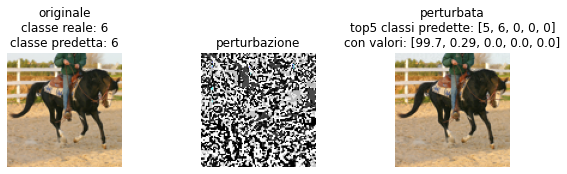

Immagine  1


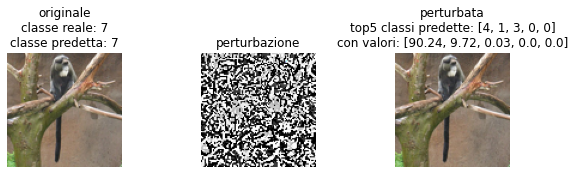

Immagine  2


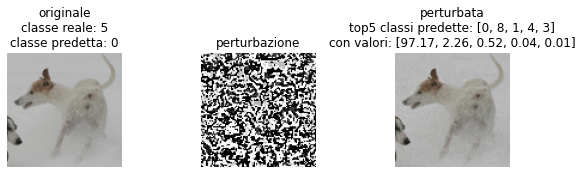

Immagine  3


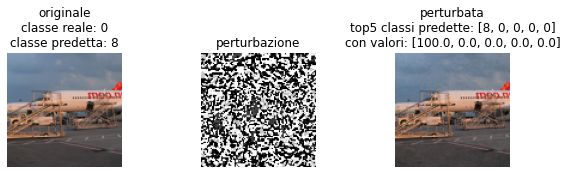

Immagine  4


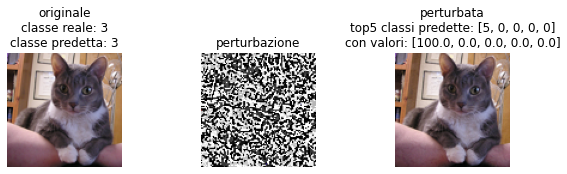

Immagine  5


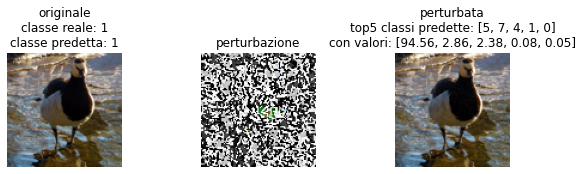

Immagine  6


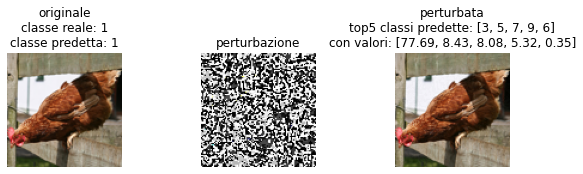

Immagine  7


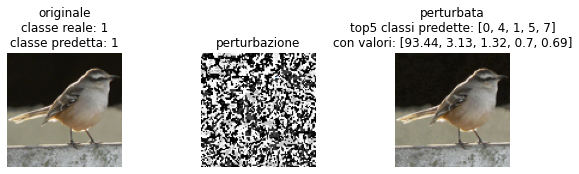

Immagine  8


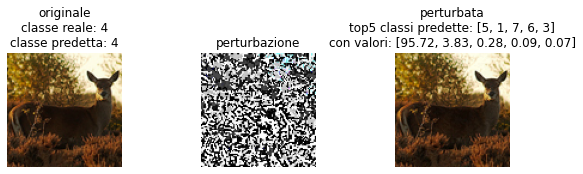

Immagine  9


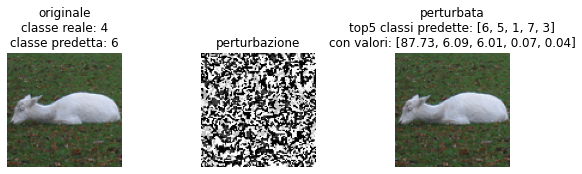

In [21]:
#stampa subplot

#cv2_imshow(cv2.hconcat([x_test[0,:,:,:]*255,x_test[1,:,:,:]*255,x_test[2,:,:,:]*255]))
#N.B. plt.imshow usa range 0,1 per immagini rgb, mentre cv2 usa 0,255
import matplotlib.pyplot as plt    
#nel seguente ciclo for si crea un vettore delle classi predette ordinato per probabilità decrescente
for i in range(10):#(x_test.shape[0]):
  value=(value_preds_after[i,:]*100).round(2)
  value_sorted=sorted(value,reverse=True)
  classes=[]
  for j in range(value.size) :
    ind=np.where(value==value_sorted[j]) #restituisce l'indice in value del valore uguale a value_sorted[i], quindi è la classe
    classes.append(ind[0][0]) #classes è il vettore finale
  
  #in seguito per ogni immagine del test set si stampa un subplot
  fig = plt.figure(figsize=[9,9])
  plt.subplots_adjust(wspace=0.7)
  print('\033[1m'+"Immagine "+'\033[1m',i) #valore END: '\033[0m'
  #originale
  ax1 = fig.add_subplot(131) #subplot con 3 righe e due colonne
  ax1.axis('off')
  ax1.imshow(cv2.rotate(x_test[i,:,:,:],cv2.cv2.ROTATE_90_CLOCKWISE))
  ax1.title.set_text("originale\nclasse reale: "+str(np.argmax(y_test[i,:]))+"\nclasse predetta: "+str(preds[i]))
  #perturbazione
  ax2 = fig.add_subplot(132)
  ax2.imshow(cv2.rotate(perturb[i,:,:,:],cv2.cv2.ROTATE_90_CLOCKWISE))
  ax2.axis('off')
  ax2.title.set_text("perturbazione")
  #perturbata
  ax3 = fig.add_subplot(133)
  ax3.imshow(cv2.rotate(x_test_adv[i,:,:,:],cv2.cv2.ROTATE_90_CLOCKWISE))#,aspect='auto')
  ax3.axis('off')
  ax3.title.set_text("perturbata\ntop5 classi predette: "+str(classes[:5])+"\ncon valori: "+str(value_sorted[:5]))
  plt.show()
 